<h1>Poles/Zeros/Gain from Look-Up Tables (Prototyping)</h1>
KNK Feb 2021: Working off of BSM's original ipynb, factoring out numeric methods

In [1]:
from mth5_test_data.util import MTH5_TEST_DATA_DIR
print(MTH5_TEST_DATA_DIR)

/home/kkappler/.cache/iris_mt/mth5_test_data/mth5_test_data


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from matplotlib.gridspec import GridSpec
from plot_helpers import plot_response
from scipy import signal

#from tf_helpers import Fit_ZerosPolesGain_toFrequencyResponse_LM
from tf_helpers import Fit_ZerosPolesGain_toFrequencyResponse_LLSQ
from mt_metadata.timeseries.filters.plotting_helpers import plot_response
#from plot_helpers import plot_response
from iris_mt_scratch.sandbox.plot_helpers import plot_complex_response
from vectfit_python import vectfit
from zen import zen_response

%matplotlib inline


2021-03-08 18:15:01,815 [line 104] mt_metadata.setup_logger - INFO: Logging file can be found /home/kkappler/software/irismt/mt_metadata/logs/mt_metadata_debug.log
2021-03-08 18:15:01,816 [line 104] error.setup_logger - INFO: Logging file can be found /home/kkappler/software/irismt/mt_metadata/logs/mt_metadata_error.log
2021-03-08 18:15:01,821 [line 104] mt_metadata.base.schema.setup_logger - INFO: Logging file can be found /home/kkappler/software/irismt/mt_metadata/logs/metadata_schema.log


In [4]:
DEG2RAD = np.pi/180

## Load the data from data repo

In [6]:
calibration_data_dir = os.path.join(MTH5_TEST_DATA_DIR, 'calibration_files', 'LEMI_Calibration', 'Lemi-039_N131BxByBz')
calibration_file_path = os.path.join(calibration_data_dir, 'Lemi-039_N131.cal' )
df = pd.read_csv(calibration_file_path, skiprows=3, delimiter='\t')
column_labels = ['frequency', 'amplitude_x', 'phase_x', 'amplitude_y', 'phase_y', 'amplitude_z', 'phase_z']
columns_map = dict(zip(df.columns, column_labels))
df = df.rename(columns=columns_map)
print(df.columns)

Index(['frequency', 'amplitude_x', 'phase_x', 'amplitude_y', 'phase_y',
       'amplitude_z', 'phase_z'],
      dtype='object')


## Preliminary Response Curve

2021-03-08T18:16:30 [line 141] numexpr.utils._init_num_threads - INFO: NumExpr defaulting to 8 threads.


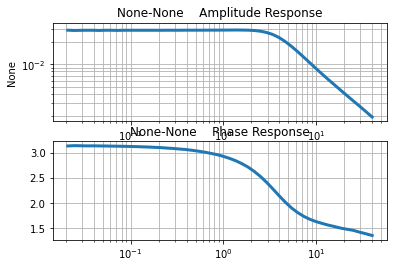

In [7]:
x_phase_radians = DEG2RAD*df['phase_x']
x_phasor = np.exp(1.J*x_phase_radians) #(np.cos( x_phase_radians)+ 1.j*np.sin(x_phase_radians))
x_complex_response = df['amplitude_x'] * x_phasor

plot_complex_response(df['frequency'], x_complex_response)
#plt.semilogx(df['frequency'], deg2rad*df['phase_x'])

## Estimate the response amplitude in the pass band

In [8]:
nominal_passband_response_amplitude = df['amplitude_x'].iloc[10].mean()
print('nominal_passband_response_amplitude', nominal_passband_response_amplitude)

nominal_passband_response_amplitude 0.02847


## Express in units of deciBels and plot on semilog

In [9]:
amplitude_in_db = 20*np.log10(df['amplitude_x']/nominal_passband_response_amplitude)

Text(0.5, 1.0, 'Amplitude Response of Instrument in dB')

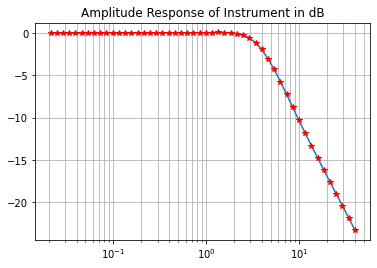

In [10]:
plt.semilogx(df['frequency'], amplitude_in_db)
plt.semilogx(df['frequency'], amplitude_in_db, 'r*')
plt.grid(which='both')
plt.title('Amplitude Response of Instrument in dB')


## Note that the decay is log-linear after about 5Hz
...
### Extend the line a bit further in log space to get an estimate of dB/decade

db_per_decade -21.8456644503


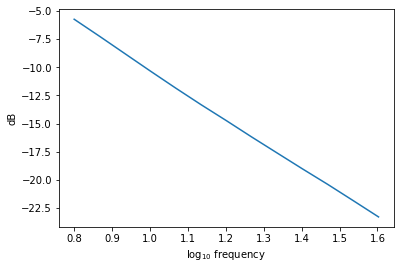

In [13]:
#The last 13 points are approximately a straight line on the log plot

frq_line = df['frequency'][-13:]
ampl_line = df['amplitude_x'][-13:]
db_line = amplitude_in_db[-13:]
log_f = np.array(np.log10(frq_line))
log_a = np.array(np.log10(ampl_line))
db = np.array(db_line)
#plt.loglog(frq_line, ampl_line)
plt.plot(log_f, db_line)
plt.xlabel('log$_{10}$ frequency')
plt.ylabel('dB')
#(log_a[-1]-log_a[0]) / (log_f[-1]-log_f[0])
db_per_decade = (db[-1]-db[0]) / (log_f[-1]-log_f[0])
print("db_per_decade", db_per_decade)#
#We need to plot this line in terms of dB, on a log plot where we clearly mark either decades or octaves
#This line may need to be extended forward in frequency, which we can do by extrapolating the line (lin logspace)

### looks like approximately -20dB/decade, which theoretically corresponds to a single pole.  We obtain a decent fit with one pole, but a better fit with 3poles and one zero.

If we want to optimize we need to add constraints however.  In particular, a regulariization that forces 1: complex poles to be conjugates, and the 'odd' poles to be pure real.  This means modifying the LLSQ process.

## Here is the solutions from Ben's ipynb using Linear Least Squares

PARAMETERIZATION: 1 zeros, 3 poles
ZerosPolesGainContinuous(
array([-32.6930273+2.42939461j]),
array([-1032.30977561-43.56871821j,   -19.41778864-14.74673119j,
         -18.02197649+16.03155314j]),
(-526.39801470067096-20.959507362663881j),
dt: None
)
[ 179.79540659  179.75234024  179.70208872  179.64345864  179.57507195
  179.49527966  179.40217388  179.29356278  179.16684673  179.01898005
  178.8464565   178.64517016  178.410237    178.13603411  177.81581382
  177.44202253  177.0053953   176.49513373  175.89830217  175.19965376
  174.38086096  173.41946116  172.28806507  170.95272126  169.37066644
  167.48772299  165.23414341  162.52155145  159.23920498  155.25505894
  150.43229023  144.6666272   137.9610296   130.52651898  122.81176697
  115.41563443  108.85673225  103.40970581   99.0809631    95.70961046
   93.07178329   90.95164762   89.16554533   87.57102514   86.05923484
   84.54805184   82.97347641   81.28337588   79.43222352   77.3808073 ]


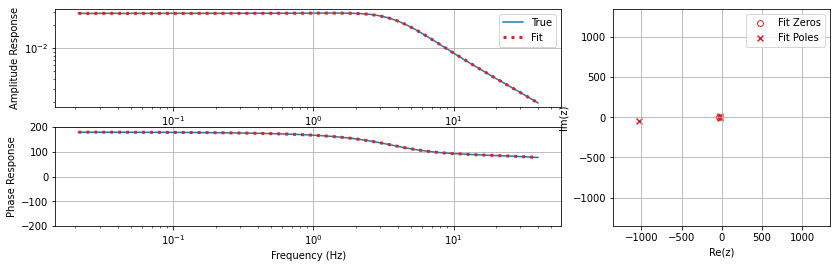

In [15]:
n_zeros = 1; n_poles = 3;
#n_zeros = 0; n_poles = 1;

print("PARAMETERIZATION: {} zeros, {} poles".format(n_zeros, n_poles))
w_obs = 2*np.pi*df['frequency']
resp_obs =  x_complex_response#df['amplitude_x']
LEMI_LM_ZPK = Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(w_obs, 
                                                        resp_obs, 
                                                        n_zeros, n_poles, useSKiter=False, 
                                                         regularize=False)
print(LEMI_LM_ZPK)
plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
              zpk_pred=LEMI_LM_ZPK, w_values=w_obs)


### We are getting complex valued zpk elements

### Lets try a purely numerical approach using scipy optimize and some regularization that penalizes deviations from the fundamental theorem of algebra solutions

If there is an odd number of poles/zeros there must be at least one purely real root
All other roots must come in complex-conjugate pairs
This means that the sum of the complex components must be zero for both the poles, the zeros and their sum.

Similarly the so-called gain factor (k) should be purely real valued.

## Set up the  problem using the classic d=G(m) framework
    -We are given an empirical resposne curve, which is a complex-valued function of frequency.  This corresponds to our data **d**
    - The model **m** is composed of three elements: first there is a tuple of complex-numbers, one per zero, zecond is a tuple of complex-numbers, one per pole, and third is a scalar multiplier.
    - G is the function linking **d** and **m**
    - Ben cast this as a linear problem but in this approach I am going to just search the model space using a direct evaluation of the zpk formula

To define the model vector we need to first define the solution _order_.  The order is defined by two integers  (n_zeros, n_poles).  Generally n_poles >= n_zeros.

The entire system is parameterized by the Laplace variable _s_  = *j* $\omega$

Ben parameterized the system like this:

$ \displaystyle h(s) = \frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} $

We are going to use


$ \displaystyle d (s) = k  \frac{(s-z_1)(s-z_2)...(s-z_m) }{(s-p_1)(s-p_2)...(s-p_n)} $




In [16]:
def add_regularization_term(zeros, poles, k, misfit, aa=0.1, verbose=False):
    if verbose:
        print('misfit in', misfit)
    #punish unbalanced imaginary components
    misfit +=  aa * np.abs(np.mean(np.sum( np.imag(zeros) )) )
    misfit += np.abs(np.mean(np.sum(np.imag(poles))))
    misfit +=  aa * np.abs(np.imag(k))
    #punish poles on rhs of plane
    for pole in poles:
        if np.real(pole)>0:
            misfit += aa * np.abs(np.real(pole) )
    if verbose:
        print('misfit out', misfit)
    return misfit

In [27]:
X_COMPLEX_RESPONSE = x_complex_response
f = df['frequency'].to_numpy()
W = 2*np.pi*f
S = 1.j*W
N_ZEROS = 1
N_POLES = 3
z0 = np.zeros(N_ZEROS, dtype=np.complex128)
p0 = np.zeros(N_POLES, dtype=np.complex128)
k0 = 1.0
MODEL_VECTOR_0 = np.hstack((z0, p0, k0))
print('MODEL_VECTOR_0',MODEL_VECTOR_0)
#Now we need a function that takes the MODEL_VECTOR as input and creates a lambda function for h(s)

def objective_function(model_vector, verbose=False):
    #unpack the model vector
    zeros = model_vector[:N_ZEROS]
    poles = model_vector[N_ZEROS:N_ZEROS+N_POLES]
    k = model_vector[-1]
    if verbose:
        print('zeros', zeros)
        print('poles', poles)
        print('k',k)
    num, den = signal.zpk2tf(zeros, poles, k)
    w, h = signal.freqs_zpk(zeros, poles, k, worN=W)
    residual = X_COMPLEX_RESPONSE - h
    misfit = np.sqrt(np.mean(np.abs(residual**2)))
    misfit = add_regularization_term(zeros, poles, k, misfit, aa=0.1)
    print('misfit',misfit)
    return misfit

objective_function(MODEL_VECTOR_0, verbose=True)

MODEL_VECTOR_0 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]
zeros [ 0.+0.j]
poles [ 0.+0.j  0.+0.j  0.+0.j]
k (1+0j)
misfit 11.9632284268


11.96322842682371

In [28]:
from scipy.optimize import minimize
method = 'nelder-mead'
#method = 'Powell'
#method = 'CG'
#method = 'Newton-CG'
res = minimize(objective_function, MODEL_VECTOR_0, method=method, options={'xatol': 1e-10, 'disp': True, })

/home/kkappler/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


misfit 11.9632284268
misfit 11.9632449554
misfit 11.9632369196
misfit 11.9632369196
misfit 11.9632369196
misfit 12.5619017262
misfit 11.3645801522
misfit 10.7659163896
misfit 11.4843273564
misfit 11.2927303862
misfit 11.0245221777
misfit 10.6490467572
misfit 9.9919394556
misfit 9.86052678988
misfit 8.80914997082
misfit 9.26940603403
misfit 8.65164889801
misfit 7.33109231463
misfit 7.4424689973
misfit 6.37173154951
misfit 4.17467853464
misfit 4.8187870514
misfit 3.76109734231
misfit 1.00725774203
misfit 1.10069609235
misfit 0.0735620060918
misfit 3.82597020273
misfit 2.91899227395
misfit 3.501547309
misfit 5.92714873822
misfit 1.64927390276
misfit 3.8085836383
misfit 1.6743899785
misfit 3.72381642231
misfit 1.2586666457
misfit 2.64541574601
misfit 0.594938109762
misfit 1.57543208527
misfit 0.76966777554
misfit 1.52811197668
misfit 0.562460335879
misfit 1.4959213696
misfit 0.452126239613
misfit 1.62456160853
misfit 0.350018648509
misfit 0.5995314049
misfit 0.258114421656
misfit 0.7650531

misfit 0.0218885302657
misfit 0.0218885057114
misfit 0.0218885361565
misfit 0.0218885023518
misfit 0.0218885327792
misfit 0.0218885090839
misfit 0.021888546224
misfit 0.0218885075009
misfit 0.0218885202961
misfit 0.0218884986973
misfit 0.0218885249694
misfit 0.0218884971371
misfit 0.0218885001429
misfit 0.0218885111563
misfit 0.0218884944416
misfit 0.0218885054994
misfit 0.0218884934434
misfit 0.0218884989046
misfit 0.0218884933807
misfit 0.0218885014951
misfit 0.0218884945264
misfit 0.0218885011658
misfit 0.0218884935578
misfit 0.0218884979209
misfit 0.0218884921536
misfit 0.0218884956647
misfit 0.0218884921928
misfit 0.0218884969628
misfit 0.0218884917164
misfit 0.0218884916175
misfit 0.021888492887
misfit 0.0218884936372
misfit 0.0218884914937
misfit 0.0218884932273
misfit 0.0218884910197
misfit 0.0218884937045
misfit 0.0218884907509
misfit 0.0218884916419
misfit 0.021888492065
misfit 0.0218884910198
misfit 0.0218884918548
misfit 0.0218884908341
misfit 0.0218884932007
misfit 0.02188

misfit 0.0218783375439
misfit 0.021878337118
misfit 0.0218783369685
misfit 0.0218783362456
misfit 0.0218783353026
misfit 0.0218783370065
misfit 0.0218783365698
misfit 0.0218783364081
misfit 0.0218783354483
misfit 0.0218783366436
misfit 0.0218783348262
misfit 0.0218783340261
misfit 0.0218783353048
misfit 0.0218783333932
misfit 0.0218783318338
misfit 0.0218783321394
misfit 0.0218783315167
misfit 0.021878329792
misfit 0.0218783300671
misfit 0.0218783279718
misfit 0.0218783254331
misfit 0.0218783257063
misfit 0.0218783244296
misfit 0.0218783212909
misfit 0.0218783200602
misfit 0.0218783146079
misfit 0.0218783155961
misfit 0.021878311663
misfit 0.0218783050483
misfit 0.0218783105359
misfit 0.0218783008306
misfit 0.0218782907825
misfit 0.0218782912262
misfit 0.0218782928438
misfit 0.0218782865784
misfit 0.0218782829544
misfit 0.0218782692881
misfit 0.0218782502285
misfit 0.0218782605229
misfit 0.0218782509182
misfit 0.0218782498976
misfit 0.0218782472509
misfit 0.0218782463339
misfit 0.02187

In [29]:
res.x


array([  1.52386429e-03,  -2.37959971e-06,  -5.45657685e-04,
        -2.57418073e-05,   8.51698777e-04])

### Looks like we are not getting back complex values here... thich could 

In [ ]:
zeros = res.x[:N_ZEROS]
poles = res.x[N_ZEROS:N_ZEROS+N_POLES]
k = res.x[-1]

In [ ]:
def make_zpk_from_model_vector(model_vector):
    zeros_real = model_vector[:2*N_ZEROS]
    poles_real = model_vector[2*N_ZEROS:2*N_ZEROS+2*N_POLES]
    k = model_vector[-1]
    zeros = np.zeros(N_ZEROS, dtype=np.complex128)
    for i_z in range(N_ZEROS):
        zeros[i_z] = np.complex(zeros_real[0+2*i_z], zeros_real[1+2*i_z])
    poles = np.zeros(N_POLES, dtype=np.complex128)
    for i_p in range(N_POLES):
        poles[i_p] = np.complex(poles_real[0+2*i_p], poles_real[1+2*i_p])
    return zeros, poles, k
        

In [ ]:
X_COMPLEX_RESPONSE = x_complex_response
f = df['frequency'].to_numpy()
W = 2*np.pi*f
S = 1.j*W
N_ZEROS = 1
N_POLES = 3
z0 = np.zeros(2*N_ZEROS)#, dtype=np.complex128)
p0 = np.zeros(2*N_POLES)#, dtype=np.complex128)
k0 = 1.0
MODEL_VECTOR_0 = np.hstack((z0, p0, k0))
print(MODEL_VECTOR_0)
print(MODEL_VECTOR_0.dtype)
#Now we need a function that takes the MODEL_VECTOR as input and creates a lambda function for h(s)

def objective_function(model_vector):
    zeros, poles, k = make_zpk_from_model_vector(model_vector)
#     zeros_real = model_vector[:2*N_ZEROS]
#     poles_real = model_vector[2*N_ZEROS:2*N_ZEROS+2*N_POLES]
#     #print('poles_real', poles_real)
#     k = model_vector[-1]
#     #print('ok')
#     zeros = np.zeros(N_ZEROS, dtype=np.complex128)
#     for i_z in range(N_ZEROS):
#         zeros[i_z] = np.complex(zeros_real[0+2*i_z], zeros_real[1+2*i_z])
#     poles = np.zeros(N_POLES, dtype=np.complex128)
#     for i_p in range(N_POLES):
#     #    print(i_p)
#         poles[i_p] = np.complex(poles_real[0+2*i_p], poles_real[1+2*i_p])
        
        
#     #print('zeros',zeros)
#     #print(poles)
#     #print(k)
    num, den = signal.zpk2tf(zeros, poles, k)
    w, h = signal.freqs_zpk(zeros, poles, k, worN=W)
    #print(h)
    #print(X_COMPLEX_RESPONSE)
    residual = X_COMPLEX_RESPONSE - h
    #print(residual)
    misfit = np.sqrt(np.mean(np.abs(residual**2)))
    misfit = add_regularization_term(zeros, poles, k, misfit, aa=100.0)
    
    print(misfit)
    return misfit

#h = lambda:s
objective_function(MODEL_VECTOR_0)

In [ ]:
from scipy.optimize import minimize
method = 'nelder-mead'
#method = 'Powell'
#method = 'CG'
#method = 'Newton-CG'
res = minimize(objective_function, MODEL_VECTOR_0, method=method, options={'xatol': 1e-10, 'disp': True, })

In [ ]:
res.x

In [ ]:
zeros, poles, k = make_zpk_from_model_vector(res.x)
print('zeros', zeros)
print('poles', poles)
print('k', k)

In [ ]:
plot_response(resp_obs=resp_obs, w_obs=w_obs, x_units='frequency', 
              zpk_pred=LEMI_LM_ZPK, w_values=w_obs)

In [ ]:
NIMS_LM_ZPK.poles =np.array([-1032.9,   -18.71-15.37j,
         -18.71+15.37j])
NIMS_LM_ZPK.zeros[0] = -32.78


<h2>Non-Linear Least Squares Fitting</h2>

Using nonlinear least squares with Levenberg-Marquardt step length damping to fit poles and zeros representation to look-up table of complex system response. Nominally, the target function is of the form

             
$ 
\displaystyle zpk(s) = k \frac{(s-z_{1})(s-z_{2})(s-z_{3})...(s-z_{m})}{(s-p_{1})(s-p_{2})(s-p_{3})...(s-p_{n})}
$

where s is complex frequency ($s = i\omega$, where $\omega$ is angular frequency), $k$ is the overall system gain, $z$ represents the $m$ system zeros, and $p$ represents the $n$ system poles.
   
HOWEVER. We're actually going to fit the look-up table with the transfer function form of the system response function:

        
$ \displaystyle h(s) = \frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} $

where $ a_{x} $ and $ b_{x} $ are the (real) coefficients on the numerator and denominator polynomials, $m$ is the number of system zeros (also the degree of the numerator polynomial), $n$ is the number of system poles (also the degree of the denominator polynomial), and $s$ is complex frequency ($s = i\omega$, where $\omega$ in angular frequency).

This form has several benefits. First of all, because the coefficients are real, the roots of these polynomials (and therefore the poles/zeros) will occur as complex conjugate pairs, which is what we expect/require for a real linear system operating on a real time series (I think...). Having real coefficients in this polynomial form also makes the math a bit easier.

Then, to find the poles/zeros, we just have to factor the numerator and denominator of this rational function. Operationally, we'll just use Python tools to do so.

For the nonlinear least squares fitting, the Jacobian is fairly simple to calculate:

$ \displaystyle \frac{\partial h(s)}{\partial a_{m}} = \frac{s^{m}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} = \frac{s^{m}}{d(s)} $

(Other partial derivatives with respect to the numerator terms are similar.)

$ \displaystyle \frac{\partial h(s)}{\partial b_{n}} = -\frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{(b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0})^{2}} s^{n} = -\frac{n(s)}{d(s)^{2}}s^{n} $

(Other partial derivatives with respect to the denominator terms are similar.)

Here, $n(s)$ and $d(s)$ are the numerator and denominator polynomials, respectively.

In the matrices here, all the numerator terms will be listed first, then all the denominator terms.

**Nonlinear LM fit to NIMS B response**

In [ ]:
print("PARAMETERIZATION: 0 zeros, 3 poles")
test_period = np.logspace(-1, 5, num=100)
test_w = 2. * np.pi / test_period
NIMS_w, NIMS_Bresp = signal.freqresp(NIMS_Magnetic_3PoleLowpass, 
                                     w=test_w)   # w is in rad/sec
NIMS_LM_ZPK = Fit_ZerosPolesGain_toFrequencyResponse_LM(NIMS_w, 
                                                        NIMS_Bresp, 
                                                        0, 3)
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, zpk_pred=NIMS_LM_ZPK, 
              w_values=test_w)

Ok, so the non-linear least squares approach isn't working so well. Apparently there's no guarantee that the model updates will be purely real (as I had hoped), and it's not converging very well. This could be because I used a bad initial guess, or because I'm doing something wrong. But let's try something else...

20210208: KNK says: maybe, but we could add some constriains to the objective function here 

<h2>Linear Least Squares</h2>

We can do some equation manipulation to turn this into a linear least squares problem. Again starting with the transfer function representation of the response function:

$ \displaystyle h(s) = \frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} = \frac{n(s)}{d(s)} $

where $ a_{x} $ and $ b_{x} $ are the (real) coefficients on the numerator and denominator polynomials, $m$ is the number of system zeros (also the degree of the numerator polynomial), $n$ is the number of system poles (also the degree of the denominator polynomial), and $s$ is complex frequency ($s = i\omega$, where $\omega$ in angular frequency).

Rearranging this equation...

$ d(s) \cdot h(s) = n(s) $

$ \displaystyle (b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}) \cdot h(s) = a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0} $

If we require $ b_{0} = 1 $, then we can get this into a convenient linear least squares form. (Note that $ b_{0} = 1 $ just means that all the other polynomial coefficients are effectively normalized by whatever $ b_{0} $ would've been before.)

$ \displaystyle b_{n}s^{n} \cdot h(s) + b_{n-1}s^{n-1} \cdot h(s) + ... + b_{1}s^{1} \cdot h(s) + 1 \cdot h(s) = a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0} $

$ \displaystyle h(s) = a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0} - b_{n}s^{n} \cdot h(s) - b_{n-1}s^{n-1} \cdot h(s) - ... - b_{1}s^{1} \cdot h(s) $

So now we can have the complex response values $ h(s) $ in the RHS vector $ \mathbf d $; the coefficients $ a_{m} $ and $ b_{m} $ as the model parameter $ \mathbf m $; $ s^{m} $ and $ - s^{n} \cdot h(s) $ in the design matrix $ \mathbf G $.

$ \displaystyle \mathbf d = \mathbf G \mathbf m $

$ \begin{bmatrix} h(s_{0}) \\ h(s_{1}) \\ \vdots \\ h(s_{k}) \end{bmatrix} = 
\begin{bmatrix} 
s_{0}^{m} & s_{0}^{m-1} & \dots & s_{0}^{1} & 1 & -s_{0}^{n} \cdot h(s_{0}) & -s_{0}^{n-1} \cdot h(s_{0}) & \dots & -s_{0}^{1} \cdot h(s_{0}) \\ 
s_{1}^{m} & s_{1}^{m-1} & \dots & s_{1}^{1} & 1 & -s_{1}^{n} \cdot h(s_{1}) & -s_{1}^{n-1} \cdot h(s_{1}) & \dots & -s_{1}^{1} \cdot h(s_{1})\\ 
 & & & & & \vdots & & & \\ 
s_{k}^{m} & s_{k}^{m-1} & \dots & s_{k}^{1} & 1 & -s_{k}^{n} \cdot h(s_{k}) & -s_{k}^{n-1} \cdot h(s_{k}) & \dots & -s_{k}^{1} \cdot h(s_{k}) 
\end{bmatrix} 
\begin{bmatrix} a_{m} \\ a_{m-1} \\ \vdots \\ a_{1} \\ a_{0} \\ b_{n} \\ b_{n-1} \\ \vdots \\ b_{1} \end{bmatrix} $

This formulation of a linear least-squares problem is sometimes called the "error-equation" method or the Levy Method in the signal processing literature. However, this form is suboptimal, as the denominator coefficients $ b_{n} $ are effectively weighted by the response values $ h(s) $. A simple method to deal with this bias is to iteratively weight (divide) the linear least squares problem by the denominator term $ d(s_{k}) $ from the previous iteration until convergence. This is called Sanathanan-Koerner iteration.